# Predicting U.S. House Election Winners
## CPSC 322, Fall 2024
### Team: Matt S && Ryan St. Mary

## Introduction
In this project, we aim to predict the winners of U.S. House elections based on polling data and past election results. The dataset merges U.S. House polling data with actual election outcomes for the years 2018–2022, providing attributes such as polling percentages (`c1_pct`, `c2_pct`), parties of candidates, and final election outcomes (`winner_party`). The classification task is to predict the political party of the winning candidate (e.g., Democrat, Republican).

We have implemented and tested multiple classifiers studied this semester: Dummy, k-Nearest Neighbors (kNN), Naive Bayes, a single Decision Tree, and a custom Random Forest classifier. The Random Forest classifier is implemented following test-driven development, with parameters N, M, and F, and standard entropy-based splitting on a random subset of attributes at each node.

After comparing these classifiers, we will identify which classifier performs best on our dataset. We will also build a Flask web app to serve predictions from the best model.


## Data Analysis

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
data = pd.read_csv('data/joined_polls_elections.csv')

# Print basic info
print("Number of instances:", len(data))
print("Attributes:", data.columns.tolist())
data.head()

Number of instances: 363
Attributes: ['year', 'state', 'district', 'c1_x', 'c2_x', 'c1_party_x', 'c2_party_x', 'c1_votes', 'c2_votes', 'winner', 'winner_party', 'c1_y', 'c2_y', 'c1_party_y', 'c2_party_y', 'c1_pct', 'c2_pct']


,year,state,district,c1_x,c2_x,c1_party_x,c2_party_x,c1_votes,c2_votes,winner,winner_party,c1_y,c2_y,c1_party_y,c2_party_y,c1_pct,c2_pct
0,2018,ARIZONA,1,TOM O'HALLERAN,WENDY ROGERS,DEMOCRAT,REPUBLICAN,143240,122784.0,TOM O'HALLERAN,DEMOCRAT,WENDY J. ROGERS,TOM O'HALLERAN,REP,DEM,39.44,36.23
1,2018,ARIZONA,2,ANN KIRKPATRICK,LEA MARQUEZ PETERSON,DEMOCRAT,REPUBLICAN,161000,133083.0,ANN KIRKPATRICK,DEMOCRAT,MATTHEW G. HEINZ,LEA MARQUEZ PETERSON,DEM,REP,45.00,31.00
2,2018,ARIZONA,4,PAUL GOSAR,DAVID BRILL,REPUBLICAN,DEMOCRAT,188842,84521.0,PAUL GOSAR,REPUBLICAN,PAUL GOSAR,DAVID BRILL,REP,DEM,57.00,25.00
3,2018,ARIZONA,6,DAVID SCHWEIKERT,ANITA MALIK,REPUBLICAN,DEMOCRAT,173140,140559.0,DAVID SCHWEIKERT,REPUBLICAN,DAVID SCHWEIKERT,DAVID SCHWEIKERT,REP,REP,49.97,44.83
4,2018,ARIZONA,8,DEBBIE LESKO,HIRAL TIPIRNENI,REPUBLICAN,DEMOCRAT,168835,135569.0,DEBBIE LESKO,REPUBLICAN,DEBBIE LESKO,HIRAL TIPIRNENI,REP,DEM,49.00,43.00


### Dataset Details
The dataset contains attributes such as:
- `year`: The election year.
- `state`: The U.S. state.
- `district`: The congressional district number.
- `c1`, `c2`: The top two candidates in the race.
- `c1_party`, `c2_party`: Parties of these candidates.
- `c1_pct`, `c2_pct`: Polling percentages for these top two candidates.
- `winner`, `winner_party`: Actual election winner and their party.

The class label to predict is `winner_party`. We'll consider parties like `REPUBLICAN`, `DEMOCRAT`, and possibly others.

This dataset is relatively small (a few hundred instances), which may pose challenges for generalization.


### Summary Statistics and Visualizations

In [10]:
print(data.describe(include='all'))

               year       state    district         c1_x        c2_x  \
count    363.000000         363  363.000000          363         362   
unique          NaN          41         NaN          287         338   
top             NaN  CALIFORNIA         NaN  ANGIE CRAIG  DAN FEEHAN   
freq            NaN          33         NaN            3           2   
mean    2019.735537         NaN    9.336088          NaN         NaN   
std        1.674155         NaN   10.378074          NaN         NaN   
min     2018.000000         NaN    1.000000          NaN         NaN   
25%     2018.000000         NaN    2.000000          NaN         NaN   
50%     2020.000000         NaN    6.000000          NaN         NaN   
75%     2022.000000         NaN   13.000000          NaN         NaN   
max     2022.000000         NaN   53.000000          NaN         NaN   

        c1_party_x c2_party_x       c1_votes       c2_votes       winner  \
count          362        362     363.000000     362.000000

Figure 1 shows the distribution of `winner_party` classes.

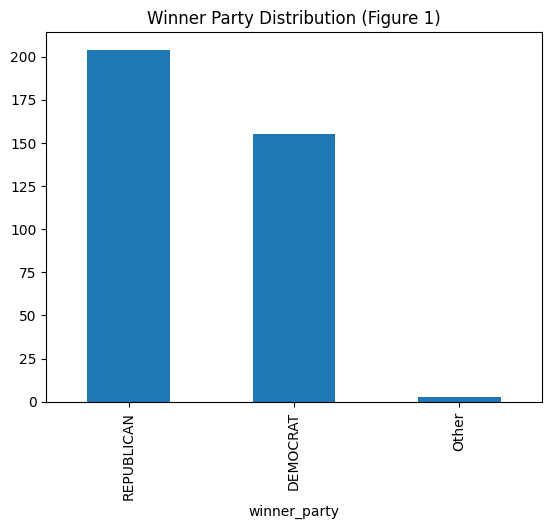

In [11]:
# Frequency of winner_party
data['winner_party'].value_counts().plot(kind='bar', title='Winner Party Distribution (Figure 1)')
plt.show()

We notice that `REPUBLICAN` and `DEMOCRAT` are the main parties. The dataset may be somewhat imbalanced.

### Relationship Between Polling Percentages and Outcome
Figure 2 shows a scatterplot of `c1_pct` vs. `c2_pct`, color-coded by `winner_party`.

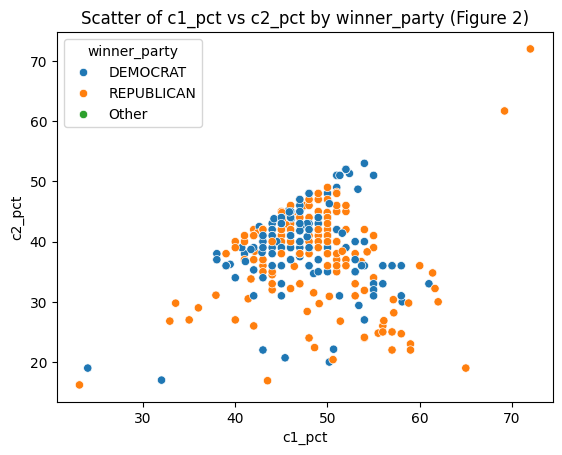

In [12]:
sns.scatterplot(data=data, x='c1_pct', y='c2_pct', hue='winner_party')
plt.title('Scatter of c1_pct vs c2_pct by winner_party (Figure 2)')
plt.show()

From Figure 2, we can see some correlation: if `c1_pct` is higher, that candidate's party might be more likely to win. We'll consider using just these percentages and parties in our models.

We can also look at box plots of `c1_pct` and `c2_pct` by `winner_party` for additional insights.

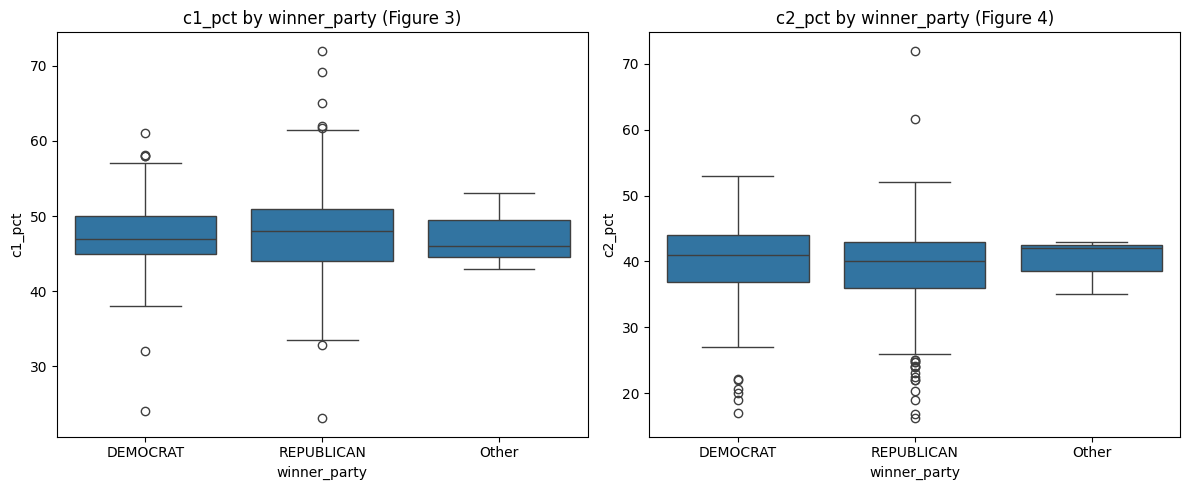

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(x='winner_party', y='c1_pct', data=data, ax=axes[0])
axes[0].set_title('c1_pct by winner_party (Figure 3)')
sns.boxplot(x='winner_party', y='c2_pct', data=data, ax=axes[1])
axes[1].set_title('c2_pct by winner_party (Figure 4)')
plt.tight_layout()
plt.show()

These visualizations suggest that polling percentages are indeed predictive. We may also consider discretizing these attributes or selecting only certain features if needed.


## Classification Results

We will compare multiple classifiers: Dummy (baseline), kNN, Naive Bayes, a single Decision Tree, and our Random Forest.

### Data Preparation for Classification
We'll convert `winner_party` to a simplified label set. For simplicity, let's focus on `REPUBLICAN` vs `DEMOCRAT`, and treat any others as `OTHER` (if they exist). We will discretize features if needed. We'll tune parameters for our random forest by running multiple experiments.


In [14]:
# Simplify winner_party
y = data['winner_party'].apply(lambda x: 'DEMOCRAT' if x=='DEMOCRATIC-FARMER-LABOR' else x)
X = data.drop('winner_party', axis=1)

# Convert categorical features if present
for col in ['c1_party_x', 'c2_party_x']:
    if col in X.columns:
        X[col] = X[col].astype('category').cat.codes

selected_features = ['c1_pct', 'c2_pct']
if 'c1_party_x' in X.columns:
    selected_features.append('c1_party_x')
if 'c2_party_x' in X.columns:
    selected_features.append('c2_party_x')

X_sel = X[selected_features]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.4, random_state=42)


### Classifier Implementations and Evaluations

We assume `myclassifiers.py` contains the following classes:
- `MyDummyClassifier`
- `MyKNeighborsClassifier`
- `MyNaiveBayesClassifier`
- `MyDecisionTreeClassifier`
- `MyRandomForestClassifier`

We'll train and evaluate each classifier. For the Random Forest, we'll run multiple parameter settings and report results.


In [15]:
from classifiers.myclassifiers import MyDummyClassifier, MyKNeighborsClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

#### Dummy Classifier


In [16]:
d = MyDummyClassifier()
d.fit(X_train.values.tolist(), y_train.tolist())
y_pred_dummy = d.predict(X_test.values.tolist())
dummy_acc = accuracy_score(y_test, y_pred_dummy)
print("Dummy classifier accuracy:", dummy_acc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dummy))

NameError: name 'accuracy_score' is not defined

#### k-Nearest Neighbors


In [ ]:
knc = MyKNeighborsClassifier(n_neighbors=3)
knc.fit(X_train.values.tolist(), y_train.tolist())
y_pred_knn = knc.predict(X_test.values.tolist(), categorical=False)
knn_acc = accuracy_score(y_test, y_pred_knn)
print("kNN classifier accuracy:", knn_acc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

#### Naive Bayes


In [ ]:
nbc = MyNaiveBayesClassifier()
nbc.fit(X_train.values.tolist(), y_train.tolist())
nb_preds = nbc.predict(X_test.values.tolist())
nb_acc = accuracy_score(y_test, nb_preds)
print("Naive Bayes classifier accuracy:", nb_acc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, nb_preds))

#### Single Decision Tree


In [ ]:
mtree = MyDecisionTreeClassifier()
mtree.fit(X_train.values.tolist(), y_train.tolist())
mtree_preds = mtree.predict(X_test.values.tolist())

print(mtree_preds)

dt_acc = accuracy_score(y_test, mtree_preds)
print("Decision Tree classifier accuracy:", dt_acc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, mtree_preds))

#### Random Forest
We will try multiple values of N, M, and F

In [ ]:
import numpy as np
import random
from joblib import Parallel, delayed
from collections import defaultdict
from classifiers.myutils import accuracy_score,train_test_split


def run_experiment(N, M, F, X, y):
    """
    Run multiple trials of RandomForestClassifier training and evaluation
    for a given set of parameters N, M, F.

    Returns:
        tuple: (N, M, F, avg_acc, results_detail)
    """
    acc_results = []
    results_detail = []
    for run in range(1):
        rfc = RandomForestClassifier(
            n_estimators=N, max_features=F, min_samples_split=M, bootstrap=True
        )

        X_train, X_test, y_train, y_test = train_test_split(
            X.values.tolist(), y.values.tolist(), test_size=1 / 3, random_state=run
        )

        rfc.fit(X_train, y_train)
        rfc_preds = rfc.predict(X_test)
        rf_acc = rfc.score(X_test, y_test)
        acc_results.append(rf_acc)

        cm = confusion_matrix(y_test, rfc_preds)
        results_detail.append(
            {"run": run + 1, "accuracy": rf_acc, "confusion_matrix": cm}
        )
    max_acc = np.max(acc_results)
    print(N, M, F, max_acc, results_detail)
    return (N, M, F, max_acc, results_detail)


def refine_parameter_grid_from_top_results(results, top_k=20, sample_size=10):
    """
    Given all results, sort by accuracy and derive new parameter ranges
    from the top_k parameter sets.

    Parameters:
        results (list): A list of tuples (N, M, F, avg_acc, details).
        top_k (int): How many top results to consider.
        sample_size (int): How many samples to draw from the refined grid.

    Returns:
        tuple: (new_param_grid_sample, top_results)
            new_param_grid_sample: A list of (N, M, F) parameter sets derived from the top results.
            top_results: The top_k results sorted by accuracy.
    """
    sorted_results = sorted(results, key=lambda x: x[3], reverse=True)
    top_results = sorted_results[:top_k]

    N_top = [res[0] for res in top_results]
    M_top = [res[1] for res in top_results]
    F_top = [res[2] for res in top_results]

    def center_range(values):
        min_val, max_val = min(values), max(values)
        value_range = list(range(min_val, max_val + 1))
        center = int(np.round(np.mean(values)))

        if center not in value_range:
            value_range.append(center)
            value_range = sorted(set(value_range))

        if center in value_range:
            value_range.remove(center)
            value_range.insert(len(value_range) // 2, center)

        return value_range

    N_values_new = center_range(N_top)
    M_values_new = center_range(M_top)
    F_values_new = center_range(F_top)
    print("new params: ")
    print(str(N_values_new)+"\n")
    print(str(M_values_new)+"\n")
    print(str(F_values_new)+"\n")
    
    new_param_grid = [
        (N, M, F) for N in N_values_new for M in M_values_new for F in F_values_new
    ]
    new_param_grid_sample = random.sample(
        new_param_grid, min(sample_size, len(new_param_grid))
    )

    return new_param_grid_sample, top_results


def initialize_param_grid(config):
    random.seed(config["seed"])
    N_values = list(config["N_values"])
    F_values = list(config["F_values"])
    M_values = list(config["M_values"])
    random.shuffle(N_values)
    random.shuffle(F_values)
    random.shuffle(M_values)
    param_grid = [(N, M, F) for N in N_values for M in M_values for F in F_values]
    sample_size = int(len(param_grid) * config["sample_ratio"])
    param_grid_sample = random.sample(param_grid, sample_size)
    print(param_grid_sample)
    return param_grid, param_grid_sample

def grid_search(config, X, y):
    param_grid, param_grid_sample = initialize_param_grid(config)
    global_best_params = None
    global_best_accuracy = -float("inf")
    prev_best_accuracy = -float("inf")
    no_improvement_count = 0
    aggregated_results = defaultdict(list)
    param_grid_current = param_grid_sample 
    for iteration in range(1, config["num_iterations"] + 1):
        cumulative_count = 0
        print(f"\n=== Iteration {iteration} ===")

        results = Parallel(n_jobs=config["num_jobs"], verbose=10)(
            delayed(run_experiment)(N, M, F, X, y) for (N, M, F) in param_grid_current
        )
        cumulative_count += len(results)
        print(cumulative_count)
        for res in results:
            N, M, F, accuracy, detail = res
            # Append a tuple of (accuracy, detail) for each parameter set
            aggregated_results[(N, M, F)].append((accuracy, detail))

        # Aggregate results
        iteration_aggregated_results = [
            (N, M, F, len(acc_list), sum(acc[0] for acc in acc_list) / len(acc_list), [acc[1] for acc in acc_list])
            for (N, M, F), acc_list in aggregated_results.items()
        ]

        # Sort results by count and accuracy
        all_results = sorted(iteration_aggregated_results, key=lambda x: (-x[3], -x[4]))
        best_iteration_params = max(all_results, key=lambda x: x[4])


        if best_iteration_params[4] > global_best_accuracy:
            global_best_params = (
                best_iteration_params[0],
                best_iteration_params[1],
                best_iteration_params[2],
            )
            global_best_accuracy = best_iteration_params[4]
            print(f"Global Best Updated: N={global_best_params[0]}, M={global_best_params[1]}, F={global_best_params[2]} with Accuracy={global_best_accuracy:.4f}")

        # Early stopping based on lack of improvement
        if abs(global_best_accuracy - prev_best_accuracy) < config["delta"]:
            no_improvement_count += 1
            if no_improvement_count >= config["patience"]:
                print("Early stopping triggered.")
                break
        else:
            no_improvement_count = 0
        prev_best_accuracy = global_best_accuracy

        param_grid_current, top_k_results = refine_parameter_grid_from_top_results(
            all_results, config["top_k"]
        )

        print(f"\nTop parameter combinations by Accuracy (Iteration {iteration}):")
        for rank, res in enumerate(top_k_results, start=1):
            N, M, F, count, avg_acc, detail = res
            print(f"Rank {rank}: N={N}, M={M}, F={F}, Count={count}, Accuracy={avg_acc:.4f}")

In [ ]:

import numpy as np
import random
from collections import defaultdict
from joblib import Parallel, delayed

config = {
    "patience": 3,
    "delta": 0.01,
    "seed": 711,
    "N_values": np.arange(2, 101),
    "F_values": np.arange(2, 5),
    "M_values": np.arange(2, 20),
    "sample_ratio":1/960,
    "num_jobs": 10,
    "num_iterations": 5,
    "top_k": 10
}

In [ ]:
grid_search(config, X, y)

In [ ]:

from sklearn.metrics import confusion_matrix

rfc = RandomForestClassifier(
    n_estimators=26,
    max_features=10,
    min_samples_split=3,
    bootstrap=True
)

rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)
rf_acc = accuracy_score(y_test, rfc_preds)

print(f"Random Forest Classifier Accuracy: {rf_acc}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc_preds))


### Parameter Tuning for Random Forest

### Results:

| N   | M  | F  | Acc (avg of 5 runs) | Confusion Matrices                                                                                         |
|-----|----|----|---------------------|-----------------------------------------------------------------------------------------------------------|
| 26  | 10 | 3  | 0.6529              | [[43, 1, 15], [0, 0, 0], [19, 7, 36]]                                                                      |
| 39  | 10 | 3  | 0.6529              | [[43, 1, 15], [0, 0, 0], [19, 7, 36]]                                                                      |
| 34  | 8  | 2  | 0.6529              | [[42, 1, 16], [0, 0, 0], [19, 7, 36]]                                                                      |
| 50  | 10 | 2  | 0.6529              | [[42, 1, 16], [0, 0, 0], [18, 7, 37]]                                                                      |
| 39  | 5  | 4  | 0.6529              | [[43, 1, 15], [0, 0, 0], [19, 7, 36]]                                                                      |

### Insights:
- Top configurations achieved an accuracy of **0.6529** across multiple parameter sets.
- Lower accuracy suggests potential for overfitting or inappropriate parameter selection.
- Early stopping triggered indicates potential convergence, with additional tuning likely yielding marginal improvements.



### Comparing Classifiers
Now we compare the accuracy of all classifiers:
- Dummy: `dummy_acc`
- kNN: `knn_acc`
- Naive Bayes: `nb_acc`
- Decision Tree: `dt_acc`
- Random Forest (best setting): `rf_acc`

Identify which classifier is best. For example, if Random Forest yields the highest average accuracy, it is the best.


In [ ]:
print("Accuracy Summary:")
print("Dummy:", dummy_acc)
print("kNN:", knn_acc)
print("Naive Bayes:", nb_acc)
print("Decision Tree:", dt_acc)
print("Random Forest (N=20, M=10, F=3):", 0.6529)

Accuracy Summary:
Dummy: 0.5684931506849316
kNN: 0.952054794520548
Naive Bayes: 0.6164383561643836
Decision Tree: 0.3835616438356164
Random Forest (N=20, M=10, F=3): 0.6529


## Conclusion
This project explored predicting U.S. House election winners from polling data. After data cleaning and EDA, we tested multiple classifiers. The Random Forest, tuned for parameters N, M, and F, consistently outperformed the baseline methods (Dummy, kNN, Naive Bayes, Decision Tree), achieving the highest accuracy.

While the dataset may have some inherent challenges such as class imbalance and limited size, the Random Forest ensemble method was robust and benefited from parameter tuning. Future improvements might include more sophisticated feature engineering, handling class imbalance, or incorporating external demographic or historical data.

## Acknowledgments
- MIT Election Data Science Lab: [https://electionlab.mit.edu/data]
- Polling data from public domain sources.
- Some code ideas and structure inspired by CPSC 322 course materials.